In [ ]:
## Mount Google Drive Data (If using Google Colaboratory)
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except:
    print("Mounting Failed.")

Mounted at /content/gdrive


In [ ]:
from torch import nn
import torch
from torchvision import models
import torchvision
from torch.nn import functional as F

def conv3x3(in_, out):
    return nn.Conv2d(in_, out, 3, padding=1)


class ConvRelu(nn.Module):
    def __init__(self, in_: int, out: int):
        super(ConvRelu, self).__init__()
        self.conv = conv3x3(in_, out)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        return x


class DecoderBlock(nn.Module):

    def __init__(self, in_channels, middle_channels, out_channels, is_deconv=True):
        super(DecoderBlock, self).__init__()
        self.in_channels = in_channels

        if is_deconv:
            self.block = nn.Sequential(
                ConvRelu(in_channels, middle_channels),
                nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=4, stride=2,
                                   padding=1),
                nn.ReLU(inplace=True)
            )
        else:
            self.block = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear'),
                ConvRelu(in_channels, middle_channels),
                ConvRelu(middle_channels, out_channels),
            )

    def forward(self, x):
        return self.block(x)
class UNet16(nn.Module):
    def __init__(self, num_classes=1, num_filters=32, pretrained=False):

        super().__init__()
        self.num_classes = num_classes

        self.pool = nn.MaxPool2d(2, 2)

        self.encoder = torchvision.models.vgg16(pretrained=pretrained).features

        self.relu = nn.ReLU(inplace=True)

        self.conv1 = nn.Sequential(self.encoder[0],
                                   self.relu,
                                   self.encoder[2],
                                   self.relu)

        self.conv2 = nn.Sequential(self.encoder[5],
                                   self.relu,
                                   self.encoder[7],
                                   self.relu)

        self.conv3 = nn.Sequential(self.encoder[10],
                                   self.relu,
                                   self.encoder[12],
                                   self.relu,
                                   self.encoder[14],
                                   self.relu)

        self.conv4 = nn.Sequential(self.encoder[17],
                                   self.relu,
                                   self.encoder[19],
                                   self.relu,
                                   self.encoder[21],
                                   self.relu)

        self.conv5 = nn.Sequential(self.encoder[24],
                                   self.relu,
                                   self.encoder[26],
                                   self.relu,
                                   self.encoder[28],
                                   self.relu)

        self.center = DecoderBlock(512, num_filters * 8 * 2, num_filters * 8)

        self.dec5 = DecoderBlock(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8)
        self.dec4 = DecoderBlock(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8)
        self.dec3 = DecoderBlock(256 + num_filters * 8, num_filters * 4 * 2, num_filters * 2)
        self.dec2 = DecoderBlock(128 + num_filters * 2, num_filters * 2 * 2, num_filters)
        self.dec1 = ConvRelu(64 + num_filters, num_filters)
        self.final = nn.Conv2d(num_filters, num_classes, kernel_size=1)

    def forward(self, x):
        conv1 = self.conv1(x)
        conv2 = self.conv2(self.pool(conv1))
        conv3 = self.conv3(self.pool(conv2))
        conv4 = self.conv4(self.pool(conv3))
        conv5 = self.conv5(self.pool(conv4))

        center = self.center(self.pool(conv5))

        dec5 = self.dec5(torch.cat([center, conv5], 1))

        dec4 = self.dec4(torch.cat([dec5, conv4], 1))
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))
        dec1 = self.dec1(torch.cat([dec2, conv1], 1))

        if self.num_classes > 1:
            x_out = F.log_softmax(self.final(dec1), dim=1)
        else:
            x_out = self.final(dec1)

        return x_out

In [ ]:
model_parts = UNet16(4)
model_parts_path="/content/gdrive/MyDrive/unet16/unet16_parts_20/model_0.pt"
state = torch.load(str(model_parts_path))
state = {key.replace('module.', ''): value for key, value in state['model'].items()}
model_parts.load_state_dict(state)
model_parts.eval()

In [ ]:
%matplotlib inline
from pylab import *
import cv2
from albumentations import Compose, RandomCrop, VerticalFlip, HorizontalFlip, Normalize, CenterCrop, Resize
from albumentations.pytorch.functional import img_to_tensor
rcParams['figure.figsize'] = 10, 10

In [ ]:
import cv2
import os

def convert_video_to_images(video_path, output_folder, num_frames=10):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error: 无法打开视频文件")
        return

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_rate = int(cap.get(cv2.CAP_PROP_FPS))

    frame_skip = max(total_frames // num_frames, 1)

    os.makedirs(output_folder, exist_ok=True)

    for i in range(0, total_frames, frame_skip):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)

        ret, frame = cap.read()

        if not ret:
            print(f"Error: 无法读取视频帧 {i}")
            break

        output_path = os.path.join(output_folder, f"frame_{int(i/frame_skip)}.png")

        cv2.imwrite(output_path, frame)

    cap.release()



In [ ]:
image_file_name="/content/gdrive/MyDrive/video_to_image/frame_0.png"
def load_image(path):
    img = cv2.imread(str(path))
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

image = load_image(image_file_name)


(720, 1280, 3)


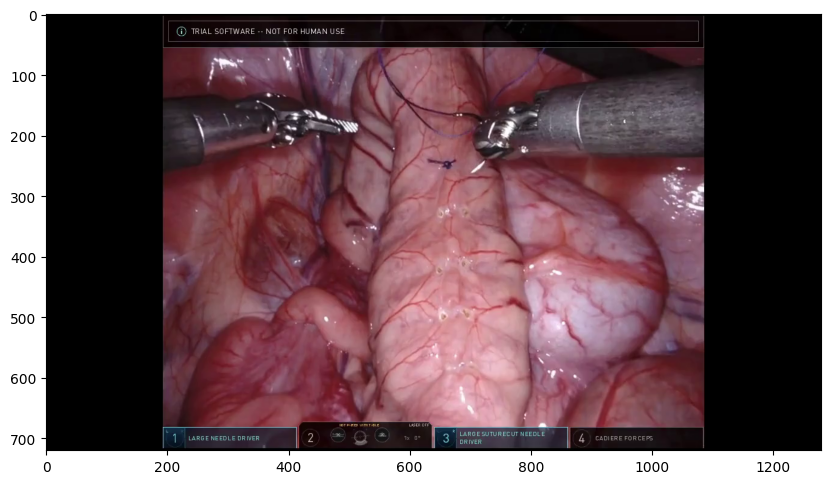

In [ ]:
print(image.shape)
imshow(image)

In [ ]:
def img_transform(p=1):
    return Compose([
        Resize(height=960, width=1280, p=1),
        Normalize(p=1)
    ], p=p)

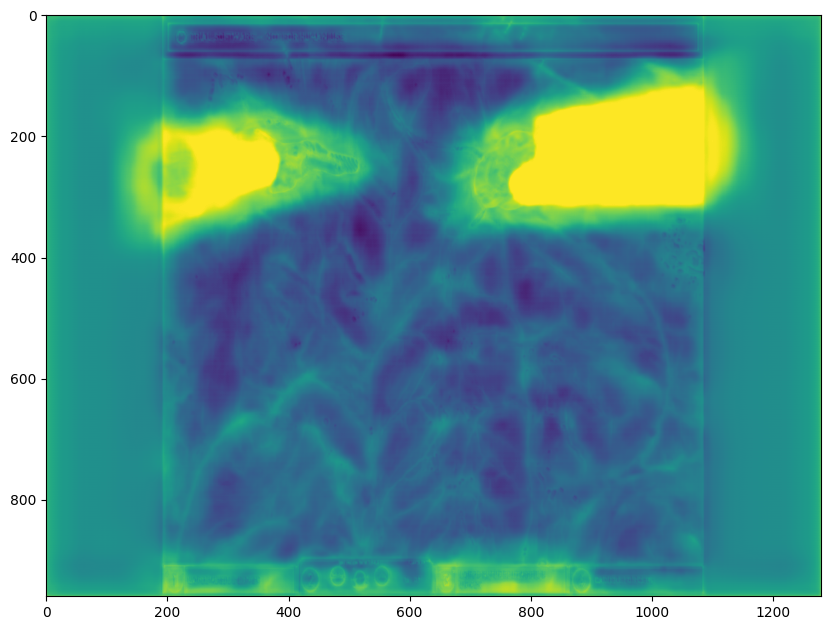

In [ ]:
with torch.no_grad():
    input_image = torch.unsqueeze(img_to_tensor(img_transform(p=1)(image=image)['image']).cuda(), dim=0)
model_parts = model_parts.cuda()
mask = model_parts(input_image)
mask_array = mask.data[0].cpu().numpy()[1]
imshow(mask_array)

In [ ]:
import pandas as pd
file = pd.read_csv("/content/gdrive/MyDrive/labels.csv")
name_list = file.iloc[:,1].tolist()

In [ ]:
print(name_list)

['clip_000000', 'clip_000001', 'clip_000002', 'clip_000003', 'clip_000004', 'clip_000005', 'clip_000006', 'clip_000007', 'clip_000008', 'clip_000009', 'clip_000010', 'clip_000011', 'clip_000012', 'clip_000013', 'clip_000014', 'clip_000015', 'clip_000016', 'clip_000017', 'clip_000018', 'clip_000019', 'clip_000020', 'clip_000021', 'clip_000022', 'clip_000023', 'clip_000024', 'clip_000025', 'clip_000026', 'clip_000027', 'clip_000028', 'clip_000029', 'clip_000030', 'clip_000031', 'clip_000032', 'clip_000033', 'clip_000034', 'clip_000035', 'clip_000036', 'clip_000037', 'clip_000038', 'clip_000039', 'clip_000040', 'clip_000041', 'clip_000042', 'clip_000043', 'clip_000044', 'clip_000045', 'clip_000046', 'clip_000047', 'clip_000048', 'clip_000049', 'clip_000050', 'clip_000051', 'clip_000052', 'clip_000053', 'clip_000054', 'clip_000055', 'clip_000056', 'clip_000057', 'clip_000058', 'clip_000059', 'clip_000060', 'clip_000061', 'clip_000062', 'clip_000063', 'clip_000064', 'clip_000065', 'clip_000

In [ ]:
import pandas as pd
dataframe = pd.read_csv("/content/gdrive/MyDrive/labels.csv")
frequencies=pd.read_csv("/content/gdrive/MyDrive/frequencts.csv")
max_frequency=max(frequencies.iloc[:,1].tolist())


In [ ]:
def get_sample_rate(name):
  name = name.replace("clip_","")
  name = int(name)
  instruments=name,dataframe.iloc[name,2]
  desired_elements = re.findall(r'\b(\w+(\s\w+)*)\b', instruments)
  instruments_list = [item[0].strip() for item in desired_elements if item[0].lower() != 'nan']
  frequency=[]
  for instrument in instruments:
    frequency.append(frequencies.iloc[frequencies['Instrument'] == instrument, 1].values[0])
  return int(max_frequency/min(frequency)*10)

In [ ]:
for name in name_list:

  video_path = f"/content/gdrive/MyDrive/video/clip_002001/{name}.mp4"

  output_folder = f"/content/gdrive/MyDrive/video_to_image/{name}"

  os.makedirs(output_folder, exist_ok=True)

  frequency= get_sample_rate(name)

  convert_video_to_images(video_path, output_folder, num_frames=10)

  break


In [ ]:
for name in name_list:
  path = f"/content/gdrive/MyDrive/video_to_image/{name}"
  try:
    os.rmdir(path)
  except:
    continue
